Location            1001                                    
Year                2021                                    
Season           Jan-Mar     Apr-Jun     Jul-Sep     Oct-Dec
Hourly Index                                                
0             108.848717  195.651168  220.210869  219.864295
1             107.679105  191.996064  219.889722  211.988777
2             109.495952  187.550719  220.250062  217.357363


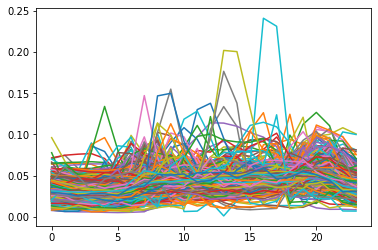

[[0.0436108  0.04314219 0.04387012 ... 0.04790975 0.04683814 0.0444319 ]
 [0.02951283 0.02896148 0.02829092 ... 0.0324561  0.03117047 0.02969376]
 [0.0180884  0.01806202 0.01809162 ... 0.02276835 0.01946528 0.0182972 ]
 ...
 [0.02989999 0.03091618 0.02841402 ... 0.04625144 0.03345146 0.03267385]
 [0.03127628 0.03067692 0.02981157 ... 0.04562448 0.03742811 0.03379835]
 [0.02963132 0.02824516 0.02525871 ... 0.04449735 0.03033335 0.03111999]]


In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

from Navajo_Load_Profiles_Functions import *


folders = create_folders()

avg_load_profiles_df = pd.read_csv(f"{folders['Aggregated Load Profiles']}\\Average Seasonal Load Profiles.csv",
                                   index_col=[0], header=[0, 1, 2])
hourly_load_profiles_df = calc_hourly_df(avg_load_profiles_df)
hourly_load_profiles_df = shift_hourly(hourly_load_profiles_df, -6)
hourly_load_profiles_df = hourly_load_profiles_df.loc[:, (hourly_load_profiles_df >= 0).all()]  # crop out cols with negatives
print(hourly_load_profiles_df.iloc[:3, :4])

X = hourly_load_profiles_df.values
X = X.T
X_norm = sklearn.preprocessing.normalize(X, norm='l1', axis=1)
plt.plot(X_norm.T)
plt.show()
print(X_norm)

Num vals in 0: 21
Num vals in 1: 20
Num vals in 2: 18
Num vals in 3: 53
Num vals in 4: 14
Num vals in 5: 24


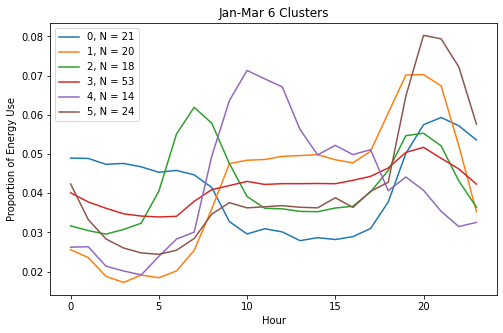

Num vals in 0: 4
Num vals in 1: 1
Num vals in 2: 25
Num vals in 3: 10
Num vals in 4: 40
Num vals in 5: 94


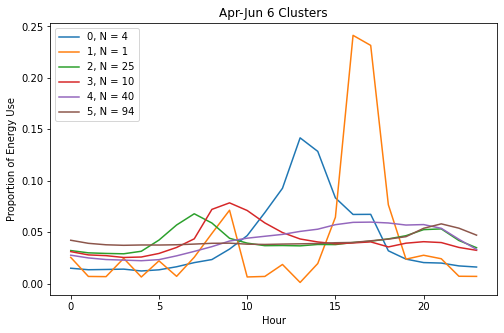

Num vals in 0: 28
Num vals in 1: 73
Num vals in 2: 21
Num vals in 3: 21
Num vals in 4: 23
Num vals in 5: 8


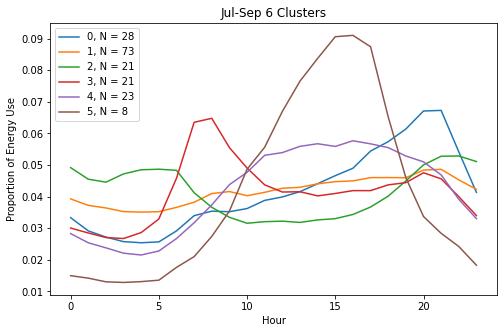

Num vals in 0: 14
Num vals in 1: 24
Num vals in 2: 19
Num vals in 3: 46
Num vals in 4: 31
Num vals in 5: 29


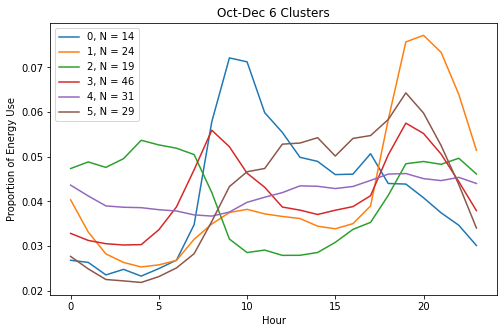

In [7]:
# Plot only the cluster centers
info_df = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], codes=[[], []], names=('Season', 'n_clusters')))
for season in ['Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec']:
    X = hourly_load_profiles_df.xs(season, axis=1, level=2).values
    X = X.T
    X_norm = sklearn.preprocessing.normalize(X, norm='l1', axis=1)
    # for n_clusters in range(3, 16):
    for n_clusters in range(6, 7):
        km = KMeans(n_clusters=n_clusters, init='random', n_init=30, max_iter=500, random_state=0)
        y_km = km.fit_predict(X_norm)

        info_df.loc[(season, n_clusters), 'inertia'] = km.inertia_
        info_df.loc[(season, n_clusters), 'logscore'] = np.log(-km.score(X_norm))
        info_df.loc[(season, n_clusters), 'silscore'] = metrics.silhouette_score(X_norm, y_km)

        plt.figure(figsize=(8,5))
        for i in list(set(km.labels_)):
            print(f"Num vals in {i}: {sum(km.labels_ == i)}")
            plt.plot(
                km.cluster_centers_[i],
                label=f'{i}, N = {sum(km.labels_ == i)}'
            )

        plt.legend(scatterpoints=1)
        plt.title(f"{season} {n_clusters} Clusters")
        plt.ylabel("Proportion of Energy Use")
        plt.xlabel("Hour")
        plt.legend(loc='upper left')
        plt.show()

In [8]:
info_df

,,inertia,logscore,silscore
Season,n_clusters,,,
Jan-Mar,6,0.312145,-1.164288,0.164679
Apr-Jun,6,0.379912,-0.967815,0.229024
Jul-Sep,6,0.246007,-1.402397,0.201396
Oct-Dec,6,0.329910,-1.108934,0.142989


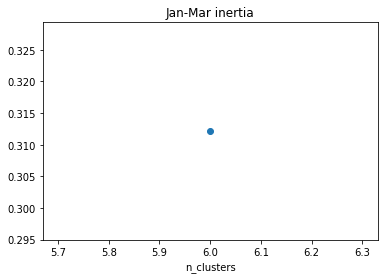

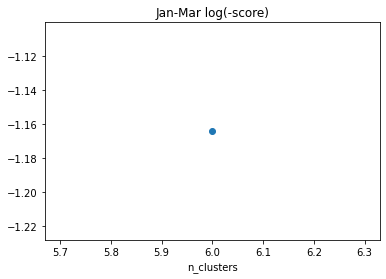

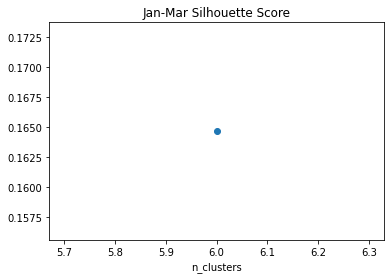

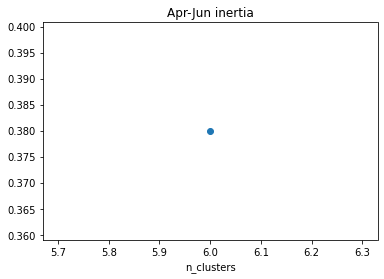

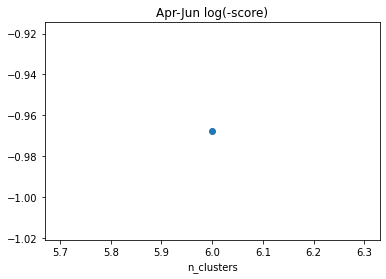

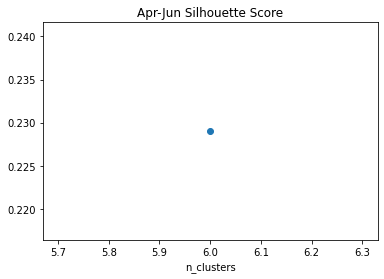

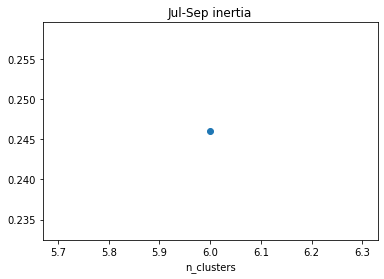

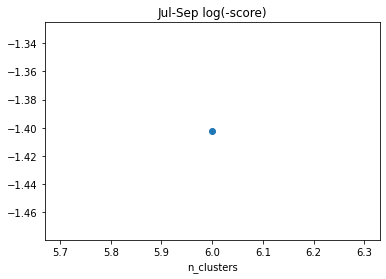

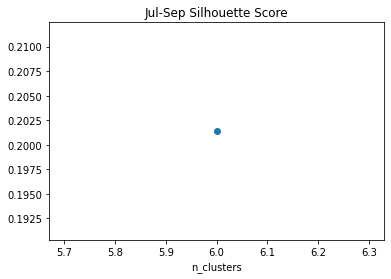

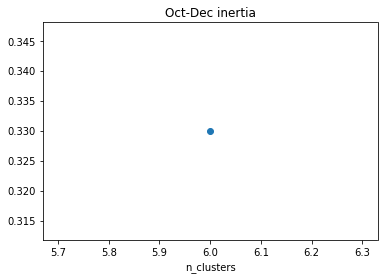

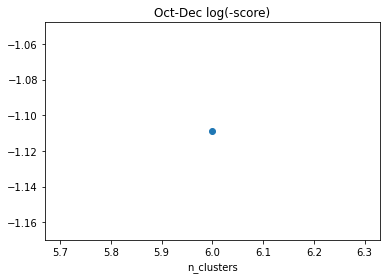

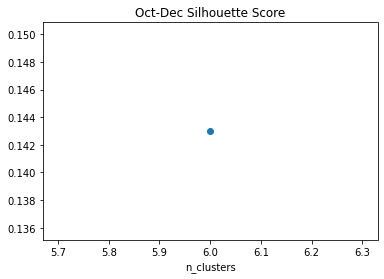

In [9]:
for season in ['Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec']:
    season_info_df = info_df.xs(season, level=0)
    plt.plot(season_info_df.index, season_info_df['inertia'], marker='o')
    plt.title(f'{season} inertia')
    plt.xlabel('n_clusters')
    plt.show()

    plt.plot(season_info_df.index, season_info_df['logscore'], marker='o')
    plt.title(f'{season} log(-score)')
    plt.xlabel('n_clusters')
    plt.show()

    plt.plot(season_info_df.index, season_info_df['silscore'], marker='o')
    plt.title(f'{season} Silhouette Score')
    plt.xlabel('n_clusters')
    plt.show()